# Слияние результатов прогнозов по Лиховидову от разных моделей.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

In [53]:
# === ЗАГРУЗКА ФАЙЛОВ ===
df_first = pd.read_csv(r"predictions_first_model.csv")
# === СМЕЩЕНИЕ ПРОГНОЗА НА 1 БАР ===
df_first["PREDICTION_SHIFTED"] = df_first["PREDICTION"].shift(1)
# df_first.drop(['CANDLE_CODE', 'PREDICTION'], axis=1, inplace=True)

df_second = pd.read_csv(r"predictions_second_model.csv")
# === СМЕЩЕНИЕ ПРОГНОЗА НА 1 БАР ===
df_second["PREDICTION_SHIFTED"] = df_second["PREDICTION"].shift(1)
# df_second.drop(['CANDLE_CODE', 'PREDICTION'], axis=1, inplace=True)

# Слияние DataFrame по пололям
df = pd.merge(
    df_first, df_second, on=['TRADEDATE', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOLUME', 'CANDLE_INT', 'CANDLE_CODE']
    )

split = int(len(df) * 0.8)  # 80% - обучающая выборка, 20% - тестовая
df = df.iloc[split:].copy()  # Берем последние 20%

df

,TRADEDATE,OPEN,LOW,HIGH,CLOSE,VOLUME,CANDLE_CODE,CANDLE_INT,PREDICTION_x,PREDICTION_SHIFTED_x,PREDICTION_y,PREDICTION_SHIFTED_y
2042,2023-03-03,94940.0,94240.0,96060.0,95550.0,85297,122,17,1.0,1.0,1.0,1.0
2043,2023-03-06,95490.0,95420.0,97230.0,96910.0,88492,110,12,0.0,1.0,1.0,1.0
2044,2023-03-07,96980.0,95680.0,97360.0,95730.0,69937,10,3,0.0,0.0,0.0,1.0
2045,2023-03-09,95720.0,95000.0,96300.0,95450.0,93626,22,8,0.0,0.0,0.0,0.0
2046,2023-03-10,95460.0,94200.0,95800.0,94750.0,74237,12,5,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2548,2025-02-27,117050.0,113780.0,117070.0,113960.0,257246,0,0,0.0,0.0,0.0,0.0
2549,2025-02-28,114000.0,111000.0,114280.0,112840.0,174134,12,5,1.0,0.0,1.0,0.0
2550,2025-03-03,112840.0,109430.0,115390.0,111100.0,256683,22,8,1.0,1.0,1.0,1.0
2551,2025-03-04,111010.0,109770.0,115630.0,115560.0,187862,101,10,0.0,1.0,1.0,1.0


In [54]:
# === РАСЧЁТ РЕЗУЛЬТАТОВ ПРОГНОЗА ===
def calculate_result(row):
    if pd.isna(row["PREDICTION_SHIFTED_x"]):  # Если NaN после сдвига
        return 0  # Можно удалить или оставить 0
    if pd.isna(row["PREDICTION_SHIFTED_y"]):  # Если NaN после сдвига
        return 0  # Можно удалить или оставить 0

    true_direction = 1 if row["CLOSE"] > row["OPEN"] else 0
    predicted_direction_x = row["PREDICTION_SHIFTED_x"]
    predicted_direction_y = row["PREDICTION_SHIFTED_y"]

    difference = abs(row["CLOSE"] - row["OPEN"])
    if (true_direction == predicted_direction_x) and (predicted_direction_x == predicted_direction_y):
        return difference
    elif(true_direction != predicted_direction_x) and (predicted_direction_x == predicted_direction_y):
        return -difference
    else:
        return 0
    
    # return difference if true_direction == predicted_direction else -difference

df["RESULT"] = df.apply(calculate_result, axis=1)
df["CUMULATIVE_RESULT"] = df["RESULT"].cumsum()

df

,TRADEDATE,OPEN,LOW,HIGH,CLOSE,VOLUME,CANDLE_CODE,CANDLE_INT,PREDICTION_x,PREDICTION_SHIFTED_x,PREDICTION_y,PREDICTION_SHIFTED_y,RESULT,CUMULATIVE_RESULT
2042,2023-03-03,94940.0,94240.0,96060.0,95550.0,85297,122,17,1.0,1.0,1.0,1.0,610.0,610.0
2043,2023-03-06,95490.0,95420.0,97230.0,96910.0,88492,110,12,0.0,1.0,1.0,1.0,1420.0,2030.0
2044,2023-03-07,96980.0,95680.0,97360.0,95730.0,69937,10,3,0.0,0.0,0.0,1.0,0.0,2030.0
2045,2023-03-09,95720.0,95000.0,96300.0,95450.0,93626,22,8,0.0,0.0,0.0,0.0,270.0,2300.0
2046,2023-03-10,95460.0,94200.0,95800.0,94750.0,74237,12,5,1.0,0.0,0.0,0.0,710.0,3010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2548,2025-02-27,117050.0,113780.0,117070.0,113960.0,257246,0,0,0.0,0.0,0.0,0.0,3090.0,146950.0
2549,2025-02-28,114000.0,111000.0,114280.0,112840.0,174134,12,5,1.0,0.0,1.0,0.0,1160.0,148110.0
2550,2025-03-03,112840.0,109430.0,115390.0,111100.0,256683,22,8,1.0,1.0,1.0,1.0,-1740.0,146370.0
2551,2025-03-04,111010.0,109770.0,115630.0,115560.0,187862,101,10,0.0,1.0,1.0,1.0,4550.0,150920.0


In [55]:
# Подсчет количества значений равных 0.0 в колонке RESULT
count_zeros = (df['RESULT'] == 0.0).sum()

# Подсчет количества положительных и отрицательных значений
num_positive = df[df['RESULT'] > 0].shape[0]
num_negative = df[df['RESULT'] < 0].shape[0]

# Суммы положительных и отрицательных значений
sum_positive = df[df['RESULT'] > 0]['RESULT'].sum()
sum_negative = df[df['RESULT'] < 0]['RESULT'].sum()

print(f"Количество значений равных 0.0: {count_zeros}")
print(f"Количество положительных значений: {num_positive}")
print(f"Количество отрицательных значений: {num_negative}")
print(f"Сумма положительных значений: {sum_positive}")
print(f"Сумма отрицательных значений: {sum_negative}")

Количество значений равных 0.0: 225
Количество положительных значений: 191
Количество отрицательных значений: 95
Сумма положительных значений: 243980.0
Сумма отрицательных значений: -93060.0


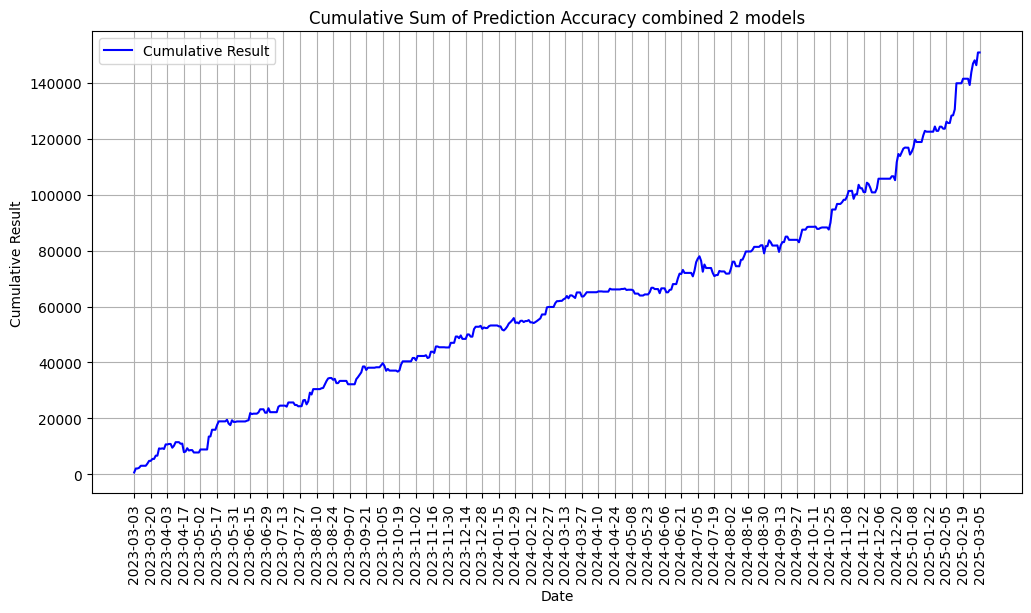

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(df["TRADEDATE"], df["CUMULATIVE_RESULT"], label="Cumulative Result", color="b")
plt.xlabel("Date")
plt.ylabel("Cumulative Result")
plt.title("Cumulative Sum of Prediction Accuracy combined 2 models")
plt.legend()
plt.grid()

# plt.xticks(rotation=45)
plt.xticks(df["TRADEDATE"][::10], rotation=90)
plt.show()

In [57]:
"""
По данным на 25 февраля 2025 года, стоимость пункта цены фьючерса RTS-3.25 
на индекс РТС (RTSI) — 1,73 рубля.
По данным на 25 февраля 2025 года, для покупки фьючерса RTS-3.25 на индекс 
РТС (RIH5) необходимо иметь на счету гарантийное обеспечение в 38 164,08
"""
df["CUM_RUB"] = df["CUMULATIVE_RESULT"] * 1.73

df

,TRADEDATE,OPEN,LOW,HIGH,CLOSE,VOLUME,CANDLE_CODE,CANDLE_INT,PREDICTION_x,PREDICTION_SHIFTED_x,PREDICTION_y,PREDICTION_SHIFTED_y,RESULT,CUMULATIVE_RESULT,CUM_RUB
2042,2023-03-03,94940.0,94240.0,96060.0,95550.0,85297,122,17,1.0,1.0,1.0,1.0,610.0,610.0,1055.3
2043,2023-03-06,95490.0,95420.0,97230.0,96910.0,88492,110,12,0.0,1.0,1.0,1.0,1420.0,2030.0,3511.9
2044,2023-03-07,96980.0,95680.0,97360.0,95730.0,69937,10,3,0.0,0.0,0.0,1.0,0.0,2030.0,3511.9
2045,2023-03-09,95720.0,95000.0,96300.0,95450.0,93626,22,8,0.0,0.0,0.0,0.0,270.0,2300.0,3979.0
2046,2023-03-10,95460.0,94200.0,95800.0,94750.0,74237,12,5,1.0,0.0,0.0,0.0,710.0,3010.0,5207.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2548,2025-02-27,117050.0,113780.0,117070.0,113960.0,257246,0,0,0.0,0.0,0.0,0.0,3090.0,146950.0,254223.5
2549,2025-02-28,114000.0,111000.0,114280.0,112840.0,174134,12,5,1.0,0.0,1.0,0.0,1160.0,148110.0,256230.3
2550,2025-03-03,112840.0,109430.0,115390.0,111100.0,256683,22,8,1.0,1.0,1.0,1.0,-1740.0,146370.0,253220.1
2551,2025-03-04,111010.0,109770.0,115630.0,115560.0,187862,101,10,0.0,1.0,1.0,1.0,4550.0,150920.0,261091.6


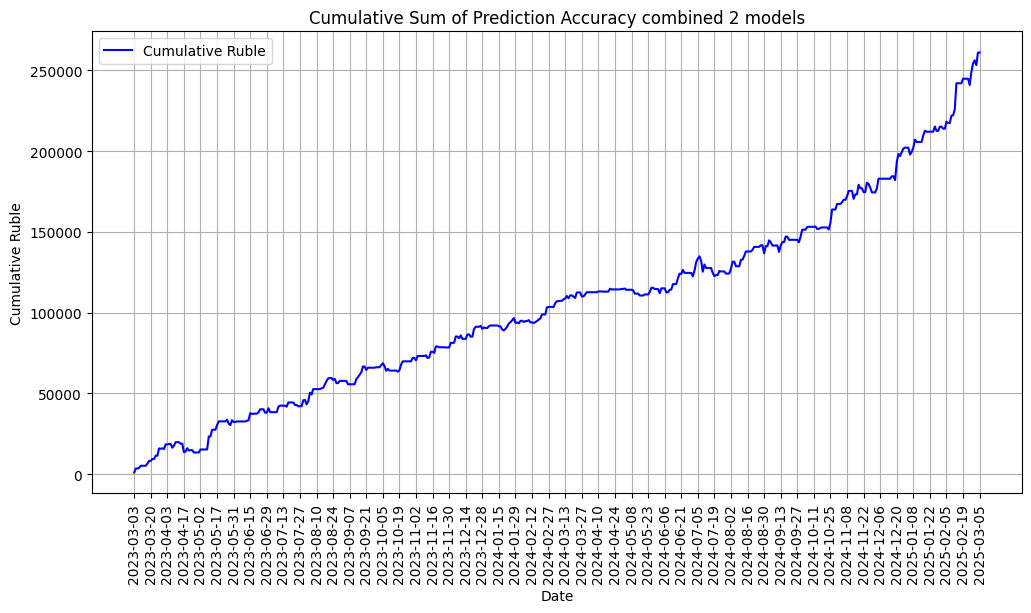

In [58]:
plt.figure(figsize=(12, 6))
# plt.plot(df["TRADEDATE"], df["CUMULATIVE_RESULT"], label="Cumulative Result", color="b")
plt.plot(df["TRADEDATE"], df["CUM_RUB"], label="Cumulative Ruble", color="b")
plt.xlabel("Date")
plt.ylabel("Cumulative Ruble")
plt.title("Cumulative Sum of Prediction Accuracy combined 2 models")
plt.legend()
plt.grid()

# plt.xticks(rotation=45)
plt.xticks(df["TRADEDATE"][::10], rotation=90)
plt.show()